# Working with n-grams

In [1]:
import sys 
sys.path.append('../nlp/')

In [2]:
from nlp.corpus import SpacyDbCorpus

**How to use the MongoDb corpus class**

In [3]:
corpus = SpacyDbCorpus(db_name='nlp', collection='yelp')

In [4]:
matchers = [{'$or': [{'pos_': {'$in': ['NOUN', 'ADJ', 'ADV', 'VERB', 'PNOUN']}}, {'dep_': 'neg'}]}]

In [5]:
documents = []
for document in corpus.get_corpus(filters=matchers, metadata=['stars'], limit=None):
    documents.append([x['lemma'] for x in document['tokens']])

In [6]:
len(documents), documents[10]

(9998,
 ['poutine',
  'good',
  'strength',
  'place',
  'variety',
  'ambiance',
  'not',
  'say',
  'good',
  'place',
  'poutine',
  'however'])

## Mutual Information for 2-grams
$$
M(w_i, w_j) = P(w_i, w_j)\log\left(\frac{P(w_i, w_j)}{P(w_i)P(w_j)}\right)
$$
where
$$
P(w, w) = \frac{count(w, w)}{\sum\limits_{i=0}^{i=n}\sum\limits_{j=0}^{j=n} count(w_i, w_j)}
$$
and
$$
P(w) = \frac{count(w)}{\sum\limits_{i=0}^{i=n} count(w_i)}
$$

In [7]:
from nlp.ngrams import n_gram_index
import pandas as pd
from collections import defaultdict
import numpy as np 

In [8]:
U = n_gram_index(documents, n=1)
B = n_gram_index(documents, n=2)

In [9]:
p_u = U / U.sum()
p_b = B / B.sum()
unigram_threshold = 4

In [10]:
mu = defaultdict(lambda: defaultdict(lambda: 0))
for (a, b), p in p_b.items():
    if U[a] > unigram_threshold and U[b] > unigram_threshold:
        mu[(a, b)] = np.log(p) + (np.log(p) - (np.log(p_u[a]) + np.log(p_u[b])))
M = pd.Series(mu)

In [11]:
M.sort_values(ascending=False).head(20)

panna       cotta          0.036461
ho          hum           -0.523155
dim         sum           -0.662410
allergic    shellfish     -0.746299
duel        piano         -0.919051
roller      coaster       -0.954521
ice         cream         -0.971913
prix        fixe          -0.985190
above       beyond        -1.101723
identity    crisis        -1.167512
surf        turf          -1.216302
tater       tot           -1.269534
pleasantly  surprised     -1.283907
highly      recommend     -1.294524
dietary     restriction   -1.334085
at          all           -1.377258
cast        iron          -1.386201
mason       jar           -1.398624
kind        of            -1.526616
shabu       shabu         -1.560555
dtype: float64

## Exploit mutual information as a relation among words

The idea is simple: we encode each word in a vector given by the MU relations with all the other words

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
mum = defaultdict(lambda: defaultdict(lambda: 0))
for (w_i, w_j), mij in M.items():
    mum[w_i][w_j] = mij 
MM = pd.DataFrame(mum).fillna(0)

In [15]:
MM.head()

,red,white,salad,super,yum,great,addition,menu,location,clean,...,nation,hustle,alive,vaccine,arise,anal,ottoman,nicht,expedia,shepard
white,-7.513822,-9.213485,-11.946068,-11.665166,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
like,-12.535830,0.000000,-12.362906,0.000000,0.0,-12.655281,0.0,-11.078948,-12.516328,-11.046795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hair,-11.352114,-9.832901,-12.565484,0.000000,0.0,-12.857859,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
french,-10.556241,0.000000,0.000000,0.000000,0.0,-13.448281,0.0,-12.318234,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pepper,-5.041902,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualize the output by dimensionality reduction

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns

In [17]:
T = TSNE(n_components=2)
MX = T.fit_transform(MM)

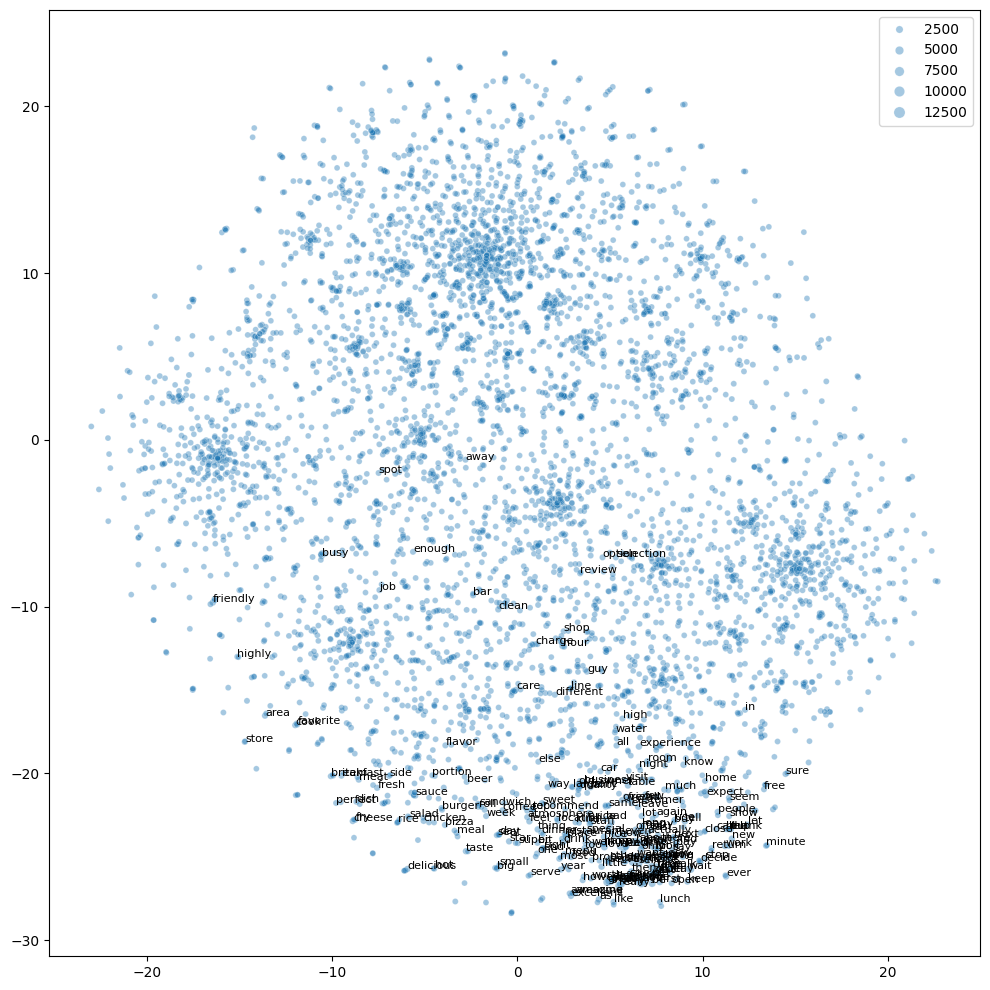

In [18]:
size = [U[x] for x in MM.index.values]

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=MX[:,0], y=MX[:,1], ax=ax, size=size, alpha=.4)
for i, label in enumerate(MM.index.values):
    x_c, y_c = MX[i][0], MX[i][1]
    if size[i] > 500:
        ax.text(x_c + .01, y_c + .01, label, fontsize=8)
plt.tight_layout()
plt.show()


### Clustering on 2 dimensions

In [19]:
from sklearn.cluster import DBSCAN

In [20]:
features = MM.index.values
ap = DBSCAN()
assignment = ap.fit_predict(MX)
clusters = defaultdict(list)
for i, cluster in enumerate(assignment):
    clusters[cluster].append(features[i])

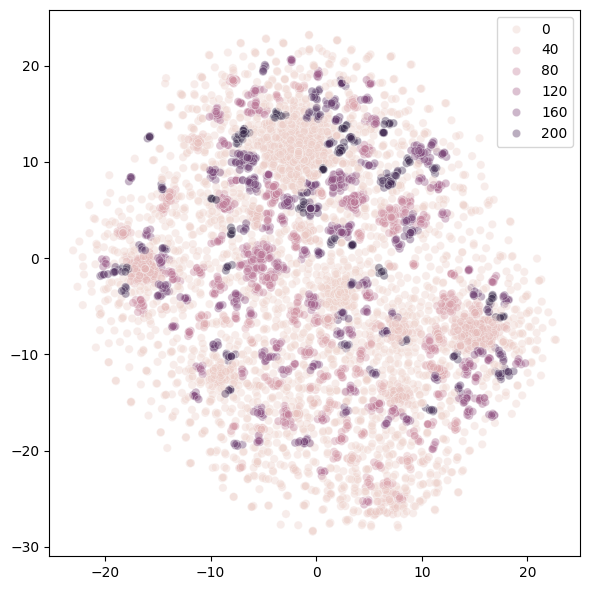

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=MX[:,0], y=MX[:,1], ax=ax, alpha=.4, hue=assignment)
plt.tight_layout()
plt.show()


In [22]:
for cluster, words in clusters.items():
    print("Words for CLUSTER {}".format(cluster))
    print(", ".join(words[:10]))
    print("================")

Words for CLUSTER -1
white, like, hair, french, pepper, meat, salsa, chili, fish, black
Words for CLUSTER 0
word, birthday, picture, actual, contact, false
Words for CLUSTER 23
flag, olive, marshmallow, cheddar, raspberry, diagnose, strict, exterior, tenant, attorney
Words for CLUSTER 1
sauce, apple, bean, tomato, bacon, veal
Words for CLUSTER 2
velvet, v, agave, leather, seaweed, sunset, transaction, mystery, ordering, caribbean
Words for CLUSTER 3
grease, seemingly, yum, cheery, sharing, duel, elevate, reduction, cornhole, broad
Words for CLUSTER 4
eye, thrilled, craft, shape, believer, ill, latte, gem, vietnamese, original
Words for CLUSTER 5
one, bit, end, right, prepare, crazy
Words for CLUSTER 12
have, also, so, not, just, pretty, good, really, always, great
Words for CLUSTER 6
wine, sandwich, roll, soup, week, hamburger, pho
Words for CLUSTER 7
cocoa, snapper, bell, :), swordfish, cry, forgive, slaw, investment, scalp
Words for CLUSTER 8
cabbage, tequila, freezer, dip, spaghetti

**Most similar**

In [23]:
sigma_x = cosine_similarity(MX, MX)
print(sigma_x.shape)

(5424, 5424)


In [29]:
def most_similar(word, sigma):
    w_i = np.where(features == word)[0][0]
    sim = pd.Series(dict([(features[i], s) for i, s in enumerate(sigma[w_i])])).sort_values(ascending=False)
    return sim

In [32]:
most_similar('pizza', sigma_x).head(10)

pizza        1.000000
lasagna      0.999999
espresso     0.999999
curry        0.999998
tofu         0.999996
vodka        0.999994
wristband    0.999993
steam        0.999992
sale         0.999990
hot          0.999988
dtype: float32

# How can we do better that this?

## Exploring the idea of using co-occurrences

For each pair of words, we just count how many times we observe the two words in the same sentence (or document)

In [33]:
import itertools

In [34]:
def pairs(tokens):
    return itertools.product(tokens, repeat=2)

In [35]:
pu = defaultdict(lambda: defaultdict(lambda: 0))
for document in documents:
    for a, b in pairs(document):
        pu[a][b] += 1
PP = pd.DataFrame(pu).fillna(0)

In [36]:
PP.head()

,red,white,salad,super,yum,great,addition,menu,location,clean,...,ladie,manuscript,librarian,romantically,overpowered,"veggies--""it",evaporated,pozole,candlelit,replica
red,337.0,39.0,47.0,20.0,1.0,143.0,10.0,96.0,35.0,20.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
white,39.0,280.0,41.0,25.0,1.0,104.0,6.0,96.0,27.0,13.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
salad,47.0,41.0,1498.0,59.0,2.0,432.0,16.0,346.0,77.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
super,20.0,25.0,59.0,732.0,2.0,317.0,10.0,101.0,69.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yum,1.0,1.0,2.0,2.0,5.0,8.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
T = TSNE(n_components=2)
PX = T.fit_transform(PP)

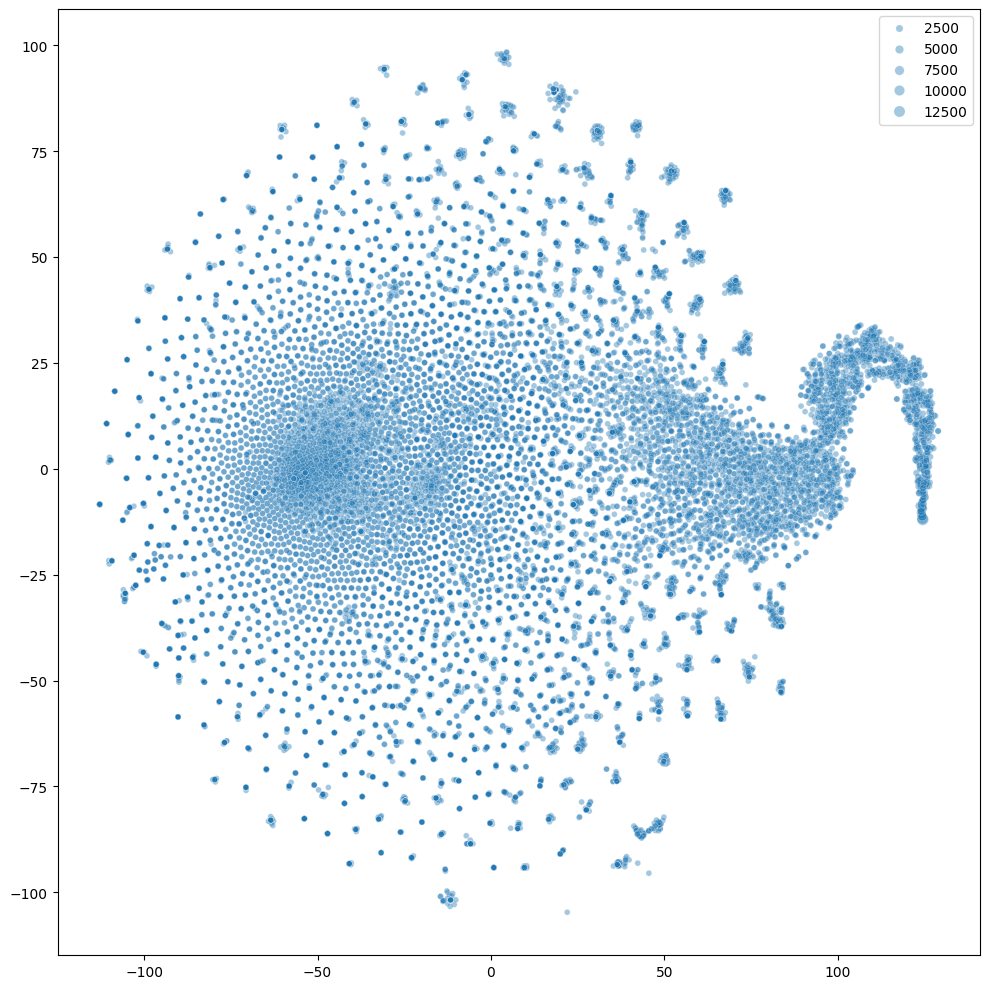

In [38]:
size = [U[x] for x in PP.index.values]

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=PX[:,0], y=PX[:,1], ax=ax, size=size, alpha=.4)
plt.tight_layout()
plt.show()

In [39]:
features = PP.index.values
ap = DBSCAN()
assignment = ap.fit_predict(PX)
clusters = defaultdict(list)
for i, cluster in enumerate(assignment):
    clusters[cluster].append(features[i])

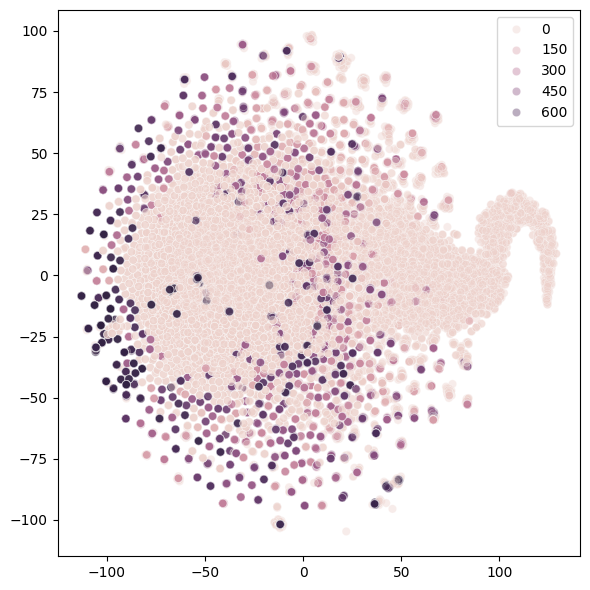

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=PX[:,0], y=PX[:,1], ax=ax, alpha=.4, hue=assignment)
plt.tight_layout()
plt.show()

In [41]:
for cluster, words in clusters.items():
    print("Words for CLUSTER {}".format(cluster))
    print(", ".join(words[:10]))
    print("================")

Words for CLUSTER -1
red, white, super, yum, great, addition, menu, location, clean, serve
Words for CLUSTER 0
salad, delicious, fresh, meat, dinner, flavor
Words for CLUSTER 1
service, be, want, try, more, only, ask, do, give, make
Words for CLUSTER 2
food, just, very, good, place, go, time, so, get, come
Words for CLUSTER 3
kiddo, merit, hangry, chadol, gen, bulgogi, yangyum, galbisal, grossly
Words for CLUSTER 9
stand, whole, less, house, once, reason, several, mean, fact
Words for CLUSTER 4
visit, many, one, bring, sit, start
Words for CLUSTER 5
bracelet, percentage, versatile, dealio, streamline
Words for CLUSTER 10
quickly, consider, before, short, forget, soon
Words for CLUSTER 16
absolutely, hope, mind, turn, yet, set
Words for CLUSTER 6
put, in, keep, about, same, decide, let
Words for CLUSTER 7
ever, long, now, all, next, sure, few, review
Words for CLUSTER 8
bio, uv, underneath, redone, equip, AWFUL, unaccommodating, disgruntled
Words for CLUSTER 11
approximately, anticipate

**Most similar**

Note that 
- we keep more dimension to better discriminate pairs of words
- we usa PCA to preserve covariance

In [45]:
from sklearn.decomposition import PCA

In [46]:
Pca = PCA(n_components=50)
P50 = Pca.fit_transform(PP)
sigma_p = cosine_similarity(P50, P50)

In [51]:
most_similar('pizza', sigma_p).head(10)

pizza       1.000000
crust       0.970459
thin        0.881890
gluten      0.842456
slice       0.839306
garlic      0.830072
topping     0.826130
wing        0.817096
mushroom    0.807362
wood        0.800615
dtype: float64